In [1]:
import warnings
from requests.exceptions import RequestsDependencyWarning

# Suppress only the noisy warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*RequestsDependencyWarning.*")
warnings.filterwarnings("ignore", category=RequestsDependencyWarning)

d:\College\Anaconda\envs\gpuacc\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2
import gc
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score, f1_score

Segmentation Models: using `keras` framework.


In [3]:
# ======================
# Build Segmentations DataFrames
# ======================
def create_segmentation_df(base_dir):
    images_dir = os.path.join(base_dir, "true")
    masks_dir  = os.path.join(base_dir, "masks")

    segmentation_data = []

    # Collect all images
    for img_fname in os.listdir(images_dir):
        img_path = os.path.join(images_dir, img_fname)
        
        # Construct corresponding mask path
        mask_path = os.path.join(masks_dir, img_fname)  # assumes same filename
        if os.path.isfile(img_path) and os.path.isfile(mask_path):
            segmentation_data.append([img_path, mask_path])

    # Create DataFrame
    seg_df = pd.DataFrame(segmentation_data, columns=["image_path", "mask_path"])
    seg_df = seg_df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
    return seg_df


# ======================
# Main dataset paths
# ======================
train_dir = r"D:\Graduation Project\data\Video\Frames\Training\labeled"
val_dir   = r"D:\Graduation Project\data\Video\Frames\Validation\labeled"
test_dir  = r"D:\Graduation Project\data\Video\Frames\Testing\labeled"

train_seg_df = create_segmentation_df(train_dir)
val_seg_df   = create_segmentation_df(val_dir)
test_seg_df  = create_segmentation_df(test_dir)

# ======================
# Save DataFrames
# ======================
train_seg_df.to_csv("train_segmentation.csv", index=False)
val_seg_df.to_csv("val_segmentation.csv", index=False)
test_seg_df.to_csv("test_segmentation.csv", index=False)

# ======================
# Info
# ======================
print("Segmentation DFs sizes:", len(train_seg_df), len(val_seg_df), len(test_seg_df))

Segmentation DFs sizes: 731 158 155


In [4]:
train_seg_df.head()

,image_path,mask_path
0,D:\Graduation Project\data\Video\Frames\Traini...,D:\Graduation Project\data\Video\Frames\Traini...
1,D:\Graduation Project\data\Video\Frames\Traini...,D:\Graduation Project\data\Video\Frames\Traini...
2,D:\Graduation Project\data\Video\Frames\Traini...,D:\Graduation Project\data\Video\Frames\Traini...
3,D:\Graduation Project\data\Video\Frames\Traini...,D:\Graduation Project\data\Video\Frames\Traini...
4,D:\Graduation Project\data\Video\Frames\Traini...,D:\Graduation Project\data\Video\Frames\Traini...


In [5]:
# ------------------------
# Augmentation / Preprocessing helpers (segmentation)
# ------------------------
def preprocess_path(img_path, mask_path, img_size=(224,224)):
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)          # RGB
    img = tf.image.resize(img, img_size)                 # (h,w,3) -> float32 (values ~0-255)

    # Mask (single-channel). Use nearest when resizing to preserve labels.
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)         # single channel
    mask = tf.image.resize(mask, img_size, method='nearest')
    # normalize mask to 0/1 (most masks are 0 or 255)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return img, mask

def augment_image_mask(image, mask):
    # Random horizontal flip (same for image & mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random rotation (same angle for both; image bilinear, mask nearest)
    angle = tf.random.uniform([], -0.261, 0.261)  # ~ -15° to +15°
    image = tfa.image.rotate(image, angle, interpolation='bilinear')
    mask = tfa.image.rotate(mask, angle, interpolation='nearest')

    # Photometric transforms (image only)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)

    return image, mask

# ------------------------
# Dataset builder for segmentation
# ------------------------
def make_segmentation_dataset(df,
                              img_size=(224,224),
                              batch_size=4,
                              do_augment=False,
                              shuffle=False,
                              preprocess_fn=None):
    """
    df: DataFrame with columns "image_path" and "mask_path"
    preprocess_fn: callable that accepts a numpy image array and returns processed numpy array
                   If None -> images are normalized to [0,1] by dividing by 255.0
                   Note: preprocess_fn is applied via tf.numpy_function (works with sm.get_preprocessing)
    """
    img_paths = df["image_path"].values
    mask_paths = df["mask_path"].values

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    # decode & resize
    def _preproc_paths(ip, mp):
        return preprocess_path(ip, mp, img_size)

    ds = ds.map(lambda x, y: _preproc_paths(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    # augment (train-time)
    if do_augment:
        ds = ds.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # final image preprocessing:
    if preprocess_fn is not None:
        # wrap preprocess_fn with tf.numpy_function so it can be used inside tf.data
        def _apply_preproc(image, mask):
            image = tf.cast(image, tf.float32)  # ensure float32 (values around 0-255)
            def _py_preproc(img_np):
                # preprocess_fn expects numpy array
                return preprocess_fn(img_np)
            img = tf.numpy_function(_py_preproc, [image], tf.float32)
            # numpy_function strips shape info -> set shape back
            img.set_shape([img_size[0], img_size[1], 3])
            return img, mask
        ds = ds.map(_apply_preproc, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # simple normalization to [0,1]
        ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
# ------------------------
# Model builders
# ------------------------
def get_unet_model(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)
    return Model(inputs, outputs)

def get_sm_model(backbone_name='resnet50', input_shape=(224, 224, 3), train_backbone=True):
    # Build smp model (Unet) using segmentation_models (sm)
    model = sm.Unet(backbone_name=backbone_name, encoder_weights='imagenet',
                    input_shape=input_shape, classes=1, activation='sigmoid')

    # Freeze encoder/backbone if requested. We try both checks:
    if not train_backbone:
        for layer in model.layers:
            lname = layer.name.lower()
            if backbone_name.lower() in lname or 'encoder' in lname or 'backbone' in lname:
                layer.trainable = False
    else:
        # ensure all layers trainable (default anyway)
        for layer in model.layers:
            layer.trainable = True

    return model

# ------------------------
# Loss & Metrics
# ------------------------
bce_dice_loss = sm.losses.BinaryCELoss() + sm.losses.DiceLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# ------------------------
# Train helper
# ------------------------
def train_model(model, train_ds, val_ds, epochs=100, lr=1e-5, model_name="model"):
    ckpt_path = f'best_model_{model_name.replace(" ", "_")}.h5'
    checkpoint = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
    earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.compile(optimizer=Adam(learning_rate=lr), loss=bce_dice_loss, metrics=metrics)
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint, earlystop], verbose=1)
    return history

In [7]:
# ------------------------
# Build datasets for each backbone (uses sm.get_preprocessing)
# ------------------------
# Expect train_seg_df, val_seg_df, test_seg_df to exist with image_path & mask_path columns
assert 'train_seg_df' in globals(), "train_seg_df is not defined"
assert 'val_seg_df' in globals(), "val_seg_df is not defined"
assert 'test_seg_df' in globals(), "test_seg_df is not defined"

# Baseline (no special preprocess_fn) -> image normalized to [0,1]
train_ds_baseline = make_segmentation_dataset(train_seg_df, img_size=(224,224), batch_size=4,
                                             do_augment=True, shuffle=True, preprocess_fn=None)
val_ds_baseline   = make_segmentation_dataset(val_seg_df, img_size=(224,224), batch_size=4,
                                             do_augment=False, shuffle=False, preprocess_fn=None)
test_ds_baseline  = make_segmentation_dataset(test_seg_df, img_size=(224,224), batch_size=4,
                                             do_augment=False, shuffle=False, preprocess_fn=None)

# Preprocessing wrappers from segmentation_models for backbones
preproc_resnet34 = sm.get_preprocessing('resnet34')
preproc_resnet50 = sm.get_preprocessing('resnet50')
preproc_densenet121 = sm.get_preprocessing('densenet121')

# ResNet34 datasets
train_ds_resnet34 = make_segmentation_dataset(train_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=True, shuffle=True, preprocess_fn=preproc_resnet34)
val_ds_resnet34   = make_segmentation_dataset(val_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=False, shuffle=False, preprocess_fn=preproc_resnet34)
test_ds_resnet34  = make_segmentation_dataset(test_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=False, shuffle=False, preprocess_fn=preproc_resnet34)

# ResNet50 datasets
train_ds_resnet50 = make_segmentation_dataset(train_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=True, shuffle=True, preprocess_fn=preproc_resnet50)
val_ds_resnet50   = make_segmentation_dataset(val_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=False, shuffle=False, preprocess_fn=preproc_resnet50)
test_ds_resnet50  = make_segmentation_dataset(test_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=False, shuffle=False, preprocess_fn=preproc_resnet50)

# DenseNet121 datasets
train_ds_densenet = make_segmentation_dataset(train_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=True, shuffle=True, preprocess_fn=preproc_densenet121)
val_ds_densenet   = make_segmentation_dataset(val_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=False, shuffle=False, preprocess_fn=preproc_densenet121)
test_ds_densenet  = make_segmentation_dataset(test_seg_df, img_size=(224,224), batch_size=4,
                                              do_augment=False, shuffle=False, preprocess_fn=preproc_densenet121)

# ------------------------
# Model configs: builder + dataset mapping
# ------------------------
model_configs = [
    {
        'name': 'Original U-Net',
        'builder': lambda: get_unet_model(input_shape=(*(224,224), 3)),
        'train_ds': train_ds_baseline,
        'val_ds': val_ds_baseline,
        'test_ds': test_ds_baseline
    },
    {
        'name': 'Pretrained ResNet34 U-Net (frozen)',
        'builder': lambda: get_sm_model(backbone_name='resnet34', input_shape=(*(224,224), 3), train_backbone=False),
        'train_ds': train_ds_resnet34,
        'val_ds': val_ds_resnet34,
        'test_ds': test_ds_resnet34
    },
    {
        'name': 'Pretrained ResNet34 U-Net (trainable)',
        'builder': lambda: get_sm_model(backbone_name='resnet34', input_shape=(*(224,224), 3), train_backbone=True),
        'train_ds': train_ds_resnet34,
        'val_ds': val_ds_resnet34,
        'test_ds': test_ds_resnet34
    },
    {
        'name': 'Pretrained ResNet50 U-Net (frozen)',
        'builder': lambda: get_sm_model(backbone_name='resnet50', input_shape=(*(224,224), 3), train_backbone=False),
        'train_ds': train_ds_resnet50,
        'val_ds': val_ds_resnet50,
        'test_ds': test_ds_resnet50
    },
    {
        'name': 'Pretrained ResNet50 U-Net (trainable)',
        'builder': lambda: get_sm_model(backbone_name='resnet50', input_shape=(*(224,224), 3), train_backbone=True),
        'train_ds': train_ds_resnet50,
        'val_ds': val_ds_resnet50,
        'test_ds': test_ds_resnet50
    },
    {
        'name': 'Pretrained DenseNet121 U-Net (frozen)',
        'builder': lambda: get_sm_model(backbone_name='densenet121', input_shape=(*(224,224), 3), train_backbone=False),
        'train_ds': train_ds_densenet,
        'val_ds': val_ds_densenet,
        'test_ds': test_ds_densenet
    },
    {
        'name': 'Pretrained DenseNet121 U-Net (trainable)',
        'builder': lambda: get_sm_model(backbone_name='densenet121', input_shape=(*(224,224), 3), train_backbone=True),
        'train_ds': train_ds_densenet,
        'val_ds': val_ds_densenet,
        'test_ds': test_ds_densenet
    }
]

In [ ]:
# ------------------------
# Train & Evaluate loop
# ------------------------
histories = {}
results = {}

for cfg in model_configs:
    name = cfg['name']
    print(f"\n=== Building / Training {name} ===")
    # clear session to avoid leftover graphs / OOM
    tf.keras.backend.clear_session()
    gc.collect()

    model = cfg['builder']()
    train_ds = cfg['train_ds']
    val_ds = cfg['val_ds']
    test_ds = cfg['test_ds']

    # Train
    history = train_model(model, train_ds, val_ds, epochs=100, lr=1e-5, model_name=name)
    histories[name] = history

    # Evaluate
    print(f"\n=== Evaluating {name} on test set ===")
    res = model.evaluate(test_ds, verbose=1)
    results[name] = res
    print(f"Result for {name}: {res}")
    del model, history, train_ds, val_ds, test_ds
    K.clear_session()
    gc.collect()

# Summary
print("\nTest Results (Loss, IoU, F1-score or other metrics):")
for name, res in results.items():
    print(f"{name}: {res}")


--- Evaluating Original U-Net ---
Test set metrics: Loss=0.3256, IoU=0.6993, F1=0.8112

--- Evaluating ResNet34 U-Net Frozen ---
Test set metrics: Loss=0.0736, IoU=0.9017, F1=0.9477

--- Evaluating ResNet34 U-Net Trainable ---
Test set metrics: Loss=0.0702, IoU=0.9040, F1=0.9490

--- Evaluating ResNet50 U-Net Frozen ---
Test set metrics: Loss=0.0772, IoU=0.8971, F1=0.9447

--- Evaluating ResNet50 U-Net Trainable ---
Test set metrics: Loss=0.0818, IoU=0.8954, F1=0.9439

--- Evaluating DenseNet121 U-Net Frozen ---
Test set metrics: Loss=0.0929, IoU=0.8883, F1=0.9400

--- Evaluating DenseNet121 U-Net Trainable ---
Test set metrics: Loss=0.0750, IoU=0.9000, F1=0.9468


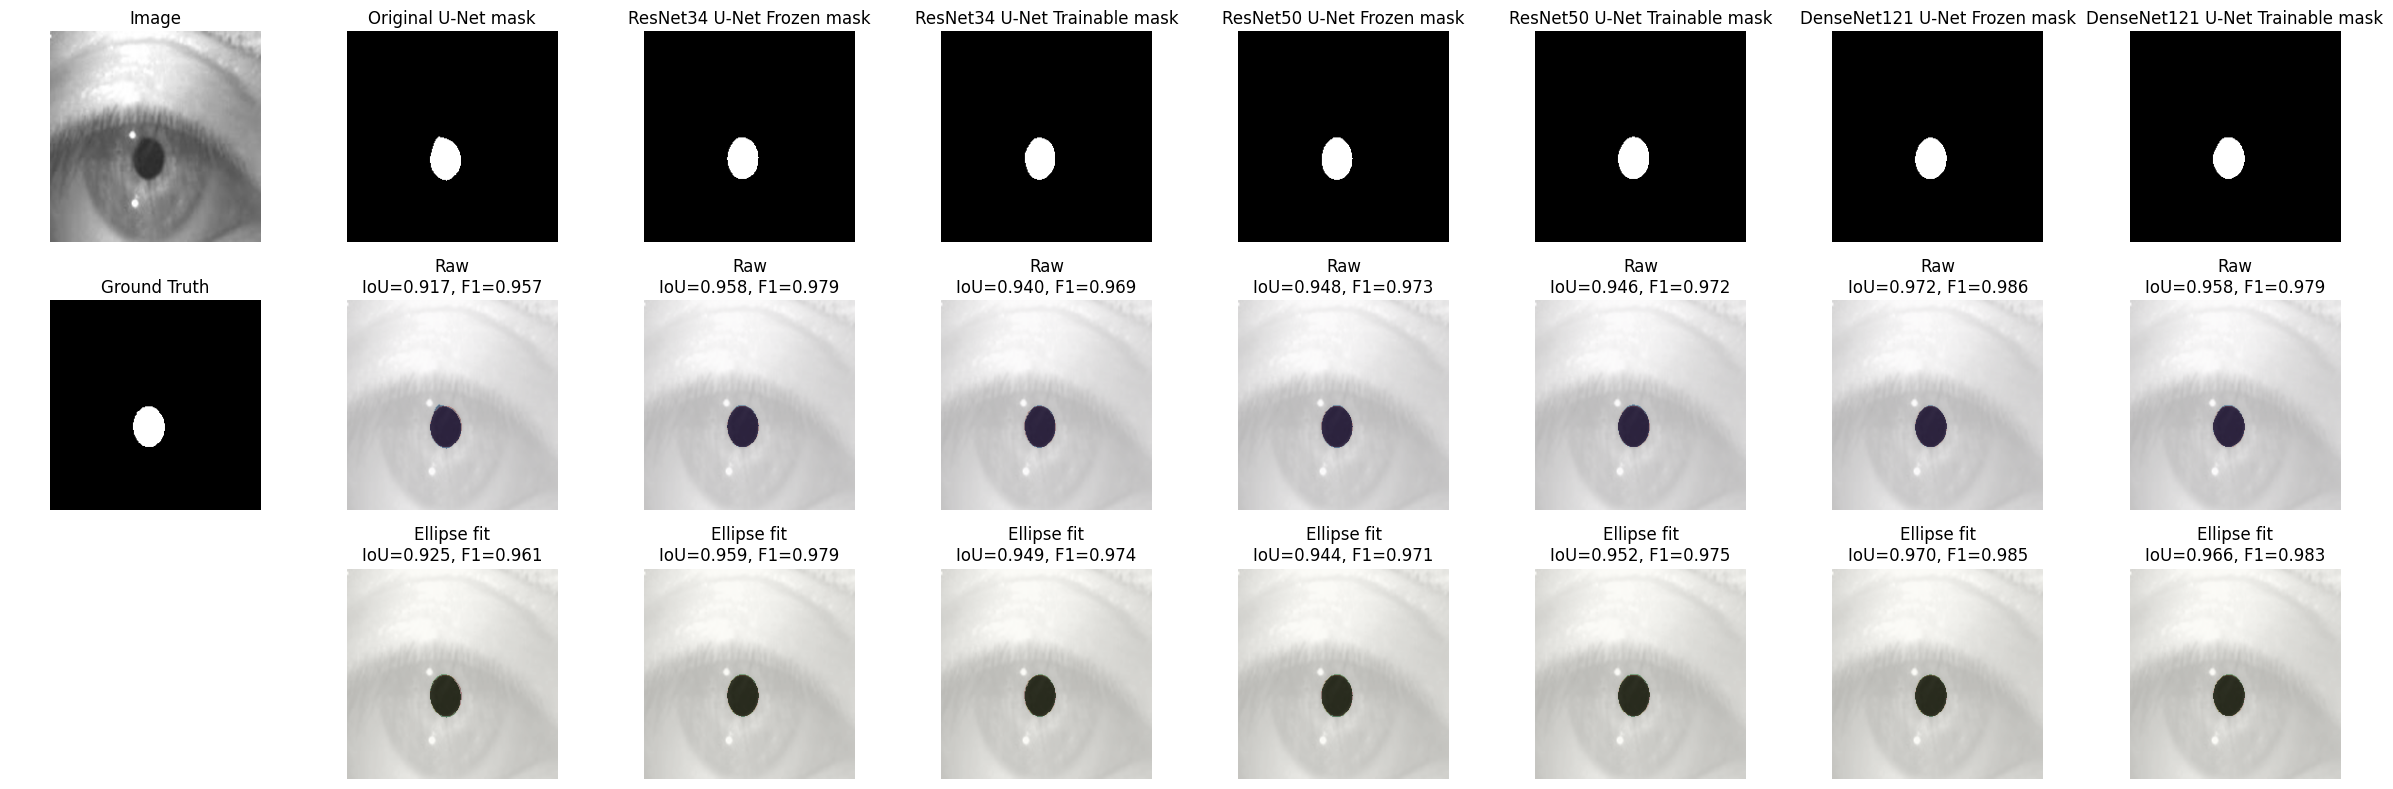

In [ ]:
# ==============================
# 0. Random sample from CSV
# ==============================
csv_file = "test_segmentation.csv"
df_test = pd.read_csv(csv_file)
rand_idx = random.randint(0, len(df_test)-1)
rand_row = df_test.iloc[rand_idx]
img_path, mask_path = rand_row["image_path"], rand_row["mask_path"]

def preprocess_path_from_csv(img_path, mask_path, img_size=(224,224), preprocess_fn=None):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method='nearest')
    mask = tf.cast(mask, tf.float32)/255.0
    mask = tf.where(mask>0.5,1.0,0.0)

    if preprocess_fn is not None:
        img_np = img.numpy()
        img_np = preprocess_fn(img_np)
        img = tf.convert_to_tensor(img_np, dtype=tf.float32)

    return img.numpy(), mask.numpy()

# Keep a copy of the original image for plotting
img, true_mask = preprocess_path_from_csv(img_path, mask_path)
img_plot = img.copy()

# ==============================
# 1. Ellipse helper
# ==============================
def fit_ellipse(pred_mask):
    mask_uint8 = (pred_mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)>0:
        cnt = max(contours, key=cv2.contourArea)
        if len(cnt)>=5:
            ellipse = cv2.fitEllipse(cnt)
            ellipse_mask = np.zeros_like(mask_uint8)
            cv2.ellipse(ellipse_mask, ellipse, 255, -1)
            return (ellipse_mask>127).astype(np.float32)
    return pred_mask

# ==============================
# 2. Overlay helper
# ==============================
def overlay_masks(img, gt_mask, pred_mask):
    overlay = img.copy()/255.0
    overlay[...,0] += pred_mask.squeeze()   # Red: prediction
    overlay[...,1] += gt_mask.squeeze()     # Green: GT
    overlay = np.clip(overlay,0,1)
    return overlay

# ==============================
# 3. Metrics
# ==============================
def calc_iou_f1(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true*y_pred)
    union = np.sum(y_true)+np.sum(y_pred)
    iou = intersection/(union-intersection+1e-7)
    f1 = 2*intersection/(union+1e-7)
    return iou, f1

# ==============================
# 4. Model info
# ==============================
model_info = [
    {"name": "Original U-Net", "file":"best_model_Original_U-Net.h5", "test_ds": test_ds_baseline, "backbone": None},
    {"name": "ResNet34 U-Net Frozen", "file":"best_model_Pretrained_ResNet34_U-Net_(frozen).h5", "test_ds": test_ds_resnet34, "backbone":"resnet34"},
    {"name": "ResNet34 U-Net Trainable", "file":"best_model_Pretrained_ResNet34_U-Net_(trainable).h5", "test_ds": test_ds_resnet34, "backbone":"resnet34"},
    {"name": "ResNet50 U-Net Frozen", "file":"best_model_Pretrained_ResNet50_U-Net_(frozen).h5", "test_ds": test_ds_resnet50, "backbone":"resnet50"},
    {"name": "ResNet50 U-Net Trainable", "file":"best_model_Pretrained_ResNet50_U-Net_(trainable).h5", "test_ds": test_ds_resnet34, "backbone":"resnet50"},
    {"name": "DenseNet121 U-Net Frozen", "file":"best_model_Pretrained_DenseNet121_U-Net_(frozen).h5", "test_ds": test_ds_densenet, "backbone":"densenet121"},
    {"name": "DenseNet121 U-Net Trainable", "file":"best_model_Pretrained_DenseNet121_U-Net_(trainable).h5", "test_ds": test_ds_densenet, "backbone":"densenet121"},
]

custom_objects = {
    "binary_crossentropy_plus_dice_loss": sm.losses.BinaryCELoss() + sm.losses.DiceLoss(),
    "iou_score": sm.metrics.IOUScore(threshold=0.9),
    "f1-score": sm.metrics.FScore(threshold=0.9)
}

# ==============================
# 5. Evaluate & predict one model at a time
# ==============================
all_results = []

for info in model_info:
    print(f"\n--- Evaluating {info['name']} ---")
    tf.keras.backend.clear_session()

    if not os.path.exists(info["file"]):
        print(f"⚠️ Model file not found: {info['file']}")
        continue

    model = load_model(info["file"], custom_objects=custom_objects)

    # Evaluate on its own test dataset
    loss, iou, f1 = model.evaluate(info["test_ds"], verbose=0)
    print(f"Test set metrics: Loss={loss:.4f}, IoU={iou:.4f}, F1={f1:.4f}")

    # Preprocess same random image
    if info["backbone"] is not None:
        preprocess_input = sm.get_preprocessing(info["backbone"])
        img_input,_ = preprocess_path_from_csv(img_path= img_path, mask_path=mask_path, preprocess_fn=preprocess_input)
    else:
        img_input,_ = preprocess_path_from_csv(img_path= img_path, mask_path=mask_path)

    # Predict
    pred_mask = model.predict(np.expand_dims(img_input, axis=0), verbose=0)[0,:,:,0]
    pred_mask = (pred_mask>0.5).astype(np.float32)
    ellipse_mask = fit_ellipse(pred_mask)

    # Compute metrics for this sample
    iou_raw, f1_raw = calc_iou_f1(true_mask, pred_mask)
    iou_ellipse, f1_ellipse = calc_iou_f1(true_mask, ellipse_mask)

    all_results.append({
        "name": info["name"],
        "loss": loss,
        "iou_test": iou,
        "f1_test": f1,
        "pred_mask": pred_mask,
        "ellipse_mask": ellipse_mask,
        "iou_raw": iou_raw,
        "f1_raw": f1_raw,
        "iou_ellipse": iou_ellipse,
        "f1_ellipse": f1_ellipse
    })

    # Free GPU
    del model
    tf.keras.backend.clear_session()
    gc.collect()

# ==============================
# 6. Plotting
# ==============================
fig, axes = plt.subplots(3, len(all_results)+1, figsize=(3*(len(all_results)+1),8))

# Original image + GT
axes[0,0].imshow(img_plot.astype(np.uint8))
axes[0,0].set_title("Image")
axes[0,0].axis("off")
axes[1,0].imshow(true_mask.squeeze(), cmap="gray")
axes[1,0].set_title("Ground Truth")
axes[1,0].axis("off")
axes[2,0].axis("off")  # empty

# Each model
for i, res in enumerate(all_results, start=1):
    # Raw mask
    axes[0,i].imshow(res["pred_mask"], cmap="gray")
    axes[0,i].set_title(f"{res['name']} mask")
    axes[0,i].axis("off")

    # Overlay raw
    axes[1,i].imshow(img_plot.astype(np.uint8))
    axes[1,i].imshow(true_mask.squeeze(), cmap="Reds", alpha=0.4)
    axes[1,i].imshow(res["pred_mask"], cmap="Blues", alpha=0.4)
    axes[1,i].set_title(f"Raw\nIoU={res['iou_raw']:.3f}, F1={res['f1_raw']:.3f}")
    axes[1,i].axis("off")

    # Overlay ellipse
    axes[2,i].imshow(img_plot.astype(np.uint8))
    axes[2,i].imshow(true_mask.squeeze(), cmap="Reds", alpha=0.4)
    axes[2,i].imshow(res["ellipse_mask"], cmap="Greens", alpha=0.4)
    axes[2,i].set_title(f"Ellipse fit\nIoU={res['iou_ellipse']:.3f}, F1={res['f1_ellipse']:.3f}")
    axes[2,i].axis("off")

plt.tight_layout()
plt.show()


=== Evaluating Original U-Net ===

📌 Results for Original U-Net
   Best IoU = 0.6922 at threshold = 0.90
   Best F1  = 0.8181 at threshold = 0.90

=== Evaluating ResNet34 U-Net Frozen ===

📌 Results for ResNet34 U-Net Frozen
   Best IoU = 0.9128 at threshold = 0.20
   Best F1  = 0.9544 at threshold = 0.20

=== Evaluating ResNet34 U-Net Trainable ===

📌 Results for ResNet34 U-Net Trainable
   Best IoU = 0.9198 at threshold = 0.10
   Best F1  = 0.9582 at threshold = 0.10

=== Evaluating ResNet50 U-Net Frozen ===

📌 Results for ResNet50 U-Net Frozen
   Best IoU = 0.9133 at threshold = 0.20
   Best F1  = 0.9547 at threshold = 0.20

=== Evaluating ResNet50 U-Net Trainable ===

📌 Results for ResNet50 U-Net Trainable
   Best IoU = 0.9086 at threshold = 0.20
   Best F1  = 0.9521 at threshold = 0.20

=== Evaluating DenseNet121 U-Net Frozen ===

📌 Results for DenseNet121 U-Net Frozen
   Best IoU = 0.9067 at threshold = 0.20
   Best F1  = 0.9511 at threshold = 0.20

=== Evaluating DenseNet121 U-

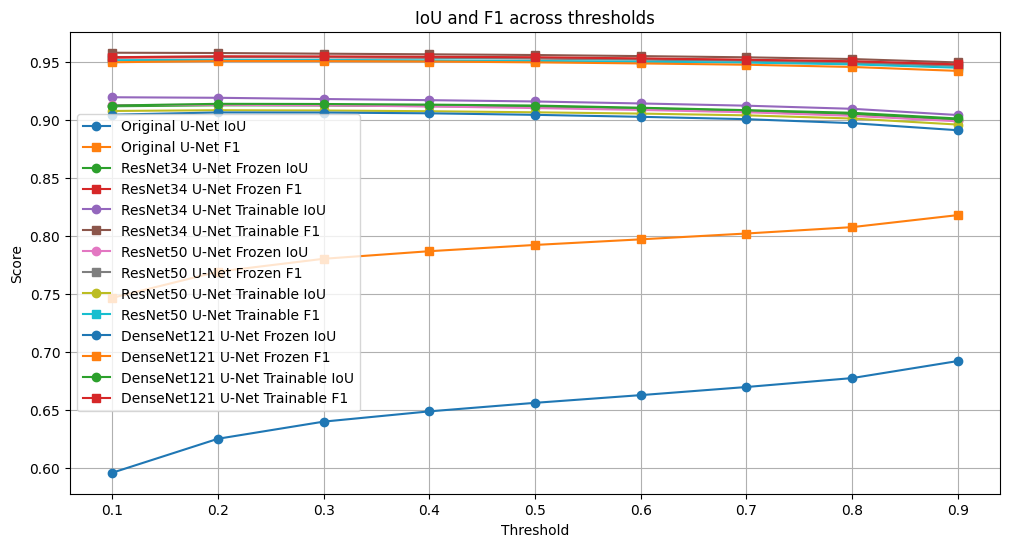

In [9]:
# ==============================
# Evaluate one model
# ==============================
def evaluate_model_thresholds(model, test_ds, model_name, thresholds=np.linspace(0.1, 0.9, 9)):
    y_true_all, y_pred_all = [], []

    # Collect predictions and GT
    for imgs, masks in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_pred_all.append(preds)
        y_true_all.append(masks)

    y_pred_all = np.concatenate(y_pred_all, axis=0)
    y_true_all = np.concatenate(y_true_all, axis=0)

    # Flatten for metrics
    y_true_flat = y_true_all.flatten()

    ious, f1s = [], []
    for t in thresholds:
        y_pred_bin = (y_pred_all >= t).astype(np.uint8).flatten()
        iou = jaccard_score(y_true_flat, y_pred_bin, average="binary")
        f1 = f1_score(y_true_flat, y_pred_bin, average="binary")
        ious.append(iou)
        f1s.append(f1)

    # Find best thresholds
    best_iou_idx = np.argmax(ious)
    best_f1_idx = np.argmax(f1s)

    print(f"\n📌 Results for {model_name}")
    print(f"   Best IoU = {ious[best_iou_idx]:.4f} at threshold = {thresholds[best_iou_idx]:.2f}")
    print(f"   Best F1  = {f1s[best_f1_idx]:.4f} at threshold = {thresholds[best_f1_idx]:.2f}")

    # Plot curves for this model
    plt.plot(thresholds, ious, marker="o", label=f"{model_name} IoU")
    plt.plot(thresholds, f1s, marker="s", label=f"{model_name} F1")

    return thresholds, ious, f1s


# ==============================
# Evaluate all models
# ==============================
def evaluate_all_models(model_info):
    plt.figure(figsize=(12, 6))

    for info in model_info:
        # Load model
        model = tf.keras.models.load_model(
            info["file"],
            custom_objects={
                "binary_crossentropy_plus_jaccard_loss": sm.losses.bce_jaccard_loss,
                "iou_score": sm.metrics.iou_score,
                "f1-score": sm.metrics.f1_score
            },
            compile=False
        )

        print(f"\n=== Evaluating {info['name']} ===")
        evaluate_model_thresholds(model, info["test_ds"], info["name"])

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("IoU and F1 across thresholds")
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_all_models(model_info)


--- Evaluating Original U-Net ---
Test set metrics: Loss=0.3256, IoU=0.6993, F1=0.8112

--- Evaluating ResNet34 U-Net Frozen ---
Test set metrics: Loss=0.0736, IoU=0.9141, F1=0.9547

--- Evaluating ResNet34 U-Net Trainable ---
Test set metrics: Loss=0.0702, IoU=0.9191, F1=0.9574

--- Evaluating ResNet50 U-Net Frozen ---
Test set metrics: Loss=0.0772, IoU=0.9111, F1=0.9527

--- Evaluating ResNet50 U-Net Trainable ---
Test set metrics: Loss=0.0818, IoU=0.9069, F1=0.9505

--- Evaluating DenseNet121 U-Net Frozen ---
Test set metrics: Loss=0.0929, IoU=0.9042, F1=0.9489

--- Evaluating DenseNet121 U-Net Trainable ---
Test set metrics: Loss=0.0750, IoU=0.9114, F1=0.9531


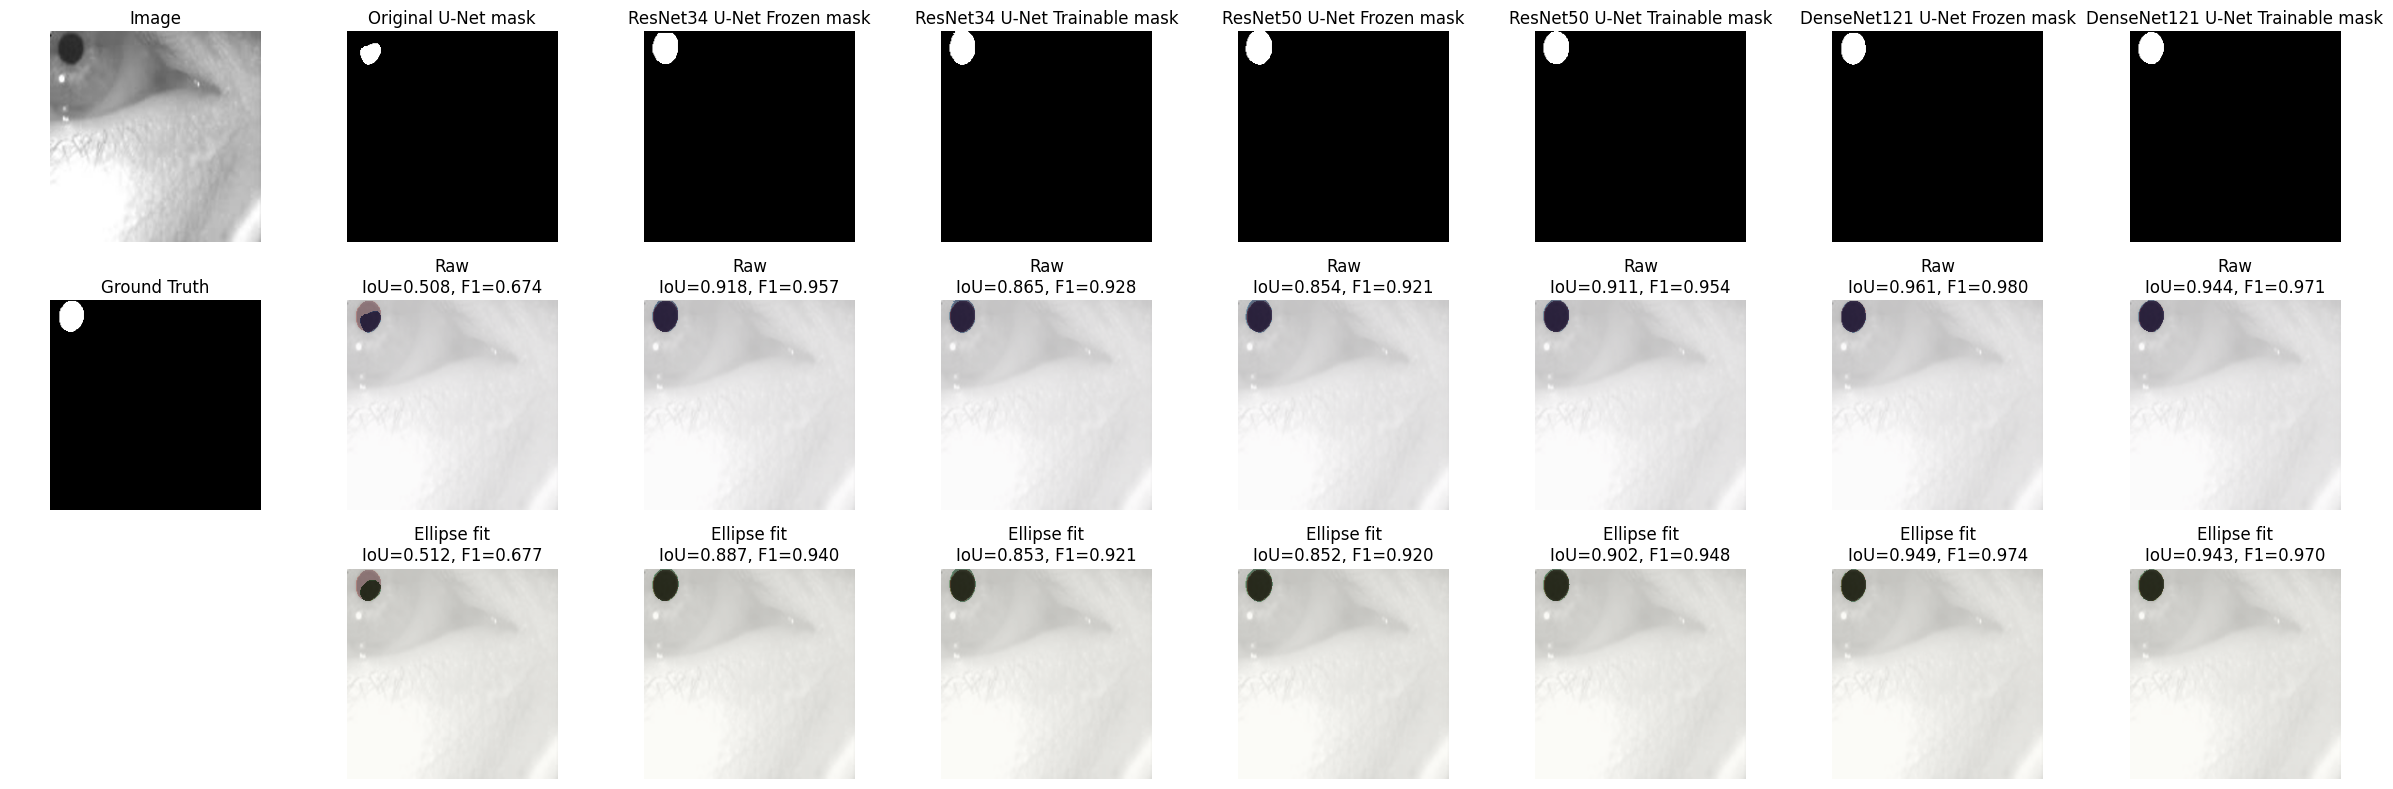

In [10]:
# ==============================
# 0. Random sample from CSV
# ==============================
csv_file = "test_segmentation.csv"
df_test = pd.read_csv(csv_file)
rand_idx = random.randint(0, len(df_test)-1)
rand_row = df_test.iloc[rand_idx]
img_path, mask_path = rand_row["image_path"], rand_row["mask_path"]

def preprocess_path_from_csv(img_path, mask_path, img_size=(224,224), preprocess_fn=None):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method='nearest')
    mask = tf.cast(mask, tf.float32)/255.0
    mask = tf.where(mask>0.5,1.0,0.0)

    if preprocess_fn is not None:
        img_np = img.numpy()
        img_np = preprocess_fn(img_np)
        img = tf.convert_to_tensor(img_np, dtype=tf.float32)

    return img.numpy(), mask.numpy()

# Keep a copy of the original image for plotting
img, true_mask = preprocess_path_from_csv(img_path, mask_path)
img_plot = img.copy()

# ==============================
# 1. Ellipse helper
# ==============================
def fit_ellipse(pred_mask):
    mask_uint8 = (pred_mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)>0:
        cnt = max(contours, key=cv2.contourArea)
        if len(cnt)>=5:
            ellipse = cv2.fitEllipse(cnt)
            ellipse_mask = np.zeros_like(mask_uint8)
            cv2.ellipse(ellipse_mask, ellipse, 255, -1)
            return (ellipse_mask>127).astype(np.float32)
    return pred_mask

# ==============================
# 2. Overlay helper
# ==============================
def overlay_masks(img, gt_mask, pred_mask):
    overlay = img.copy()/255.0
    overlay[...,0] += pred_mask.squeeze()   # Red: prediction
    overlay[...,1] += gt_mask.squeeze()     # Green: GT
    overlay = np.clip(overlay,0,1)
    return overlay

# ==============================
# 3. Metrics
# ==============================
def calc_iou_f1(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true*y_pred)
    union = np.sum(y_true)+np.sum(y_pred)
    iou = intersection/(union-intersection+1e-7)
    f1 = 2*intersection/(union+1e-7)
    return iou, f1

# ==============================
# 4. Model info
# ==============================
model_info = [
    {"name": "Original U-Net", "file":"best_model_Original_U-Net.h5", "test_ds": test_ds_baseline, "backbone": None},
    {"name": "ResNet34 U-Net Frozen", "file":"best_model_Pretrained_ResNet34_U-Net_(frozen).h5", "test_ds": test_ds_resnet34, "backbone":"resnet34"},
    {"name": "ResNet34 U-Net Trainable", "file":"best_model_Pretrained_ResNet34_U-Net_(trainable).h5", "test_ds": test_ds_resnet34, "backbone":"resnet34"},
    {"name": "ResNet50 U-Net Frozen", "file":"best_model_Pretrained_ResNet50_U-Net_(frozen).h5", "test_ds": test_ds_resnet50, "backbone":"resnet50"},
    {"name": "ResNet50 U-Net Trainable", "file":"best_model_Pretrained_ResNet50_U-Net_(trainable).h5", "test_ds": test_ds_resnet34, "backbone":"resnet50"},
    {"name": "DenseNet121 U-Net Frozen", "file":"best_model_Pretrained_DenseNet121_U-Net_(frozen).h5", "test_ds": test_ds_densenet, "backbone":"densenet121"},
    {"name": "DenseNet121 U-Net Trainable", "file":"best_model_Pretrained_DenseNet121_U-Net_(trainable).h5", "test_ds": test_ds_densenet, "backbone":"densenet121"},
]

# ==============================
# 4b. Best thresholds for each model
# ==============================
best_thresholds = {
    "Original U-Net": 0.90,
    "ResNet34 U-Net Frozen": 0.20,
    "ResNet34 U-Net Trainable": 0.10,
    "ResNet50 U-Net Frozen": 0.20,
    "ResNet50 U-Net Trainable": 0.20,
    "DenseNet121 U-Net Frozen": 0.20,
    "DenseNet121 U-Net Trainable": 0.20
}

# ==============================
# 5. Evaluate & predict one model at a time
# ==============================
all_results = []

for info in model_info:
    print(f"\n--- Evaluating {info['name']} ---")
    tf.keras.backend.clear_session()

    if not os.path.exists(info["file"]):
        print(f"⚠️ Model file not found: {info['file']}")
        continue

    threshold = best_thresholds[info["name"]]
    custom_objects = {
        "binary_crossentropy_plus_dice_loss": sm.losses.BinaryCELoss() + sm.losses.DiceLoss(),
        "iou_score": sm.metrics.IOUScore(threshold=threshold),
        "f1-score": sm.metrics.FScore(threshold=threshold)
    }

    model = load_model(info["file"], custom_objects=custom_objects)

    # Evaluate on its own test dataset
    loss, iou, f1 = model.evaluate(info["test_ds"], verbose=0)
    print(f"Test set metrics: Loss={loss:.4f}, IoU={iou:.4f}, F1={f1:.4f}")

    # Preprocess same random image
    if info["backbone"] is not None:
        preprocess_input = sm.get_preprocessing(info["backbone"])
        img_input,_ = preprocess_path_from_csv(img_path= img_path, mask_path=mask_path, preprocess_fn=preprocess_input)
    else:
        img_input,_ = preprocess_path_from_csv(img_path= img_path, mask_path=mask_path)

    # Predict
    pred_mask_probs = model.predict(np.expand_dims(img_input, axis=0), verbose=0)[0,:,:,0]

    # Apply best threshold for this model
    threshold = best_thresholds[info["name"]]
    pred_mask = (pred_mask_probs > threshold).astype(np.float32)

    ellipse_mask = fit_ellipse(pred_mask)

    # Compute metrics for this sample
    iou_raw, f1_raw = calc_iou_f1(true_mask, pred_mask)
    iou_ellipse, f1_ellipse = calc_iou_f1(true_mask, ellipse_mask)

    all_results.append({
        "name": info["name"],
        "loss": loss,
        "iou_test": iou,
        "f1_test": f1,
        "pred_mask": pred_mask,
        "ellipse_mask": ellipse_mask,
        "iou_raw": iou_raw,
        "f1_raw": f1_raw,
        "iou_ellipse": iou_ellipse,
        "f1_ellipse": f1_ellipse
    })

    # Free GPU
    del model
    tf.keras.backend.clear_session()
    gc.collect()

# ==============================
# 6. Plotting
# ==============================
fig, axes = plt.subplots(3, len(all_results)+1, figsize=(3*(len(all_results)+1),8))

# Original image + GT
axes[0,0].imshow(img_plot.astype(np.uint8))
axes[0,0].set_title("Image")
axes[0,0].axis("off")
axes[1,0].imshow(true_mask.squeeze(), cmap="gray")
axes[1,0].set_title("Ground Truth")
axes[1,0].axis("off")
axes[2,0].axis("off")  # empty

# Each model
for i, res in enumerate(all_results, start=1):
    # Raw mask
    axes[0,i].imshow(res["pred_mask"], cmap="gray")
    axes[0,i].set_title(f"{res['name']} mask")
    axes[0,i].axis("off")

    # Overlay raw
    axes[1,i].imshow(img_plot.astype(np.uint8))
    axes[1,i].imshow(true_mask.squeeze(), cmap="Reds", alpha=0.4)
    axes[1,i].imshow(res["pred_mask"], cmap="Blues", alpha=0.4)
    axes[1,i].set_title(f"Raw\nIoU={res['iou_raw']:.3f}, F1={res['f1_raw']:.3f}")
    axes[1,i].axis("off")

    # Overlay ellipse
    axes[2,i].imshow(img_plot.astype(np.uint8))
    axes[2,i].imshow(true_mask.squeeze(), cmap="Reds", alpha=0.4)
    axes[2,i].imshow(res["ellipse_mask"], cmap="Greens", alpha=0.4)
    axes[2,i].set_title(f"Ellipse fit\nIoU={res['iou_ellipse']:.3f}, F1={res['f1_ellipse']:.3f}")
    axes[2,i].axis("off")

plt.tight_layout()
plt.show()